In [9]:
using Turing: _leapfrog
using Main.Test

In [11]:
# _leapfrog(θ::T, p::Vector{Float64}, τ::Int, ϵ::Float64, lp_grad_func::Function)

lp_grad_func(x) = nothing, x

step_size = 0.1

theta_0 = rand(2)
p_0 = rand(2)

2-element Array{Float64,1}:
 0.626509
 0.566136

In [12]:
theta_1, p_1, _ = _leapfrog(theta_0, p_0, 1, step_size, lp_grad_func)

([0.241253, 0.951054], [0.605472, 0.473637], 1)

In [13]:
theta_2, p_2, _ = _leapfrog(theta_1, p_1, 1, step_size, lp_grad_func)

([0.300594, 0.993662], [0.578379, 0.376401], 1)

In [14]:
theta_2_one_call, p_2_one_call, _ = _leapfrog(theta_0, p_0, 2, step_size, lp_grad_func)

([0.300594, 0.993662], [0.578379, 0.376401], 2)

In [15]:
@test theta_2 == theta_2_one_call
@test p_2 == p_2_one_call

Test Passed

In [ ]:
# function _leapfrog(θ::T, p::Vector{Float64}, τ::Int, ϵ::Float64, lp_grad_func::Function;
#                    rev_func=nothing, log_func=nothing) where {T<:Union{Vector,SubArray}}

#   old_logp, grad = lp_grad_func(θ)
#   verifygrad(grad) || (return θ, p, 0)

#   τ_valid = 0
#   for t in 1:τ
#     # NOTE: we dont need copy here becase arr += another_arr
#     #       doesn't change arr in-place
#     p_old = p; θ_old = copy(θ)

#     p -= ϵ .* grad / 2
#     θ += ϵ .* p  # full step for state

#     if log_func != nothing log_func() end

#     old_logp, grad = lp_grad_func(θ)
#     if ~verifygrad(grad)
#       if rev_func != nothing rev_func(θ_old, old_logp) end
#       θ = θ_old; p = p_old; break
#     end

#     p -= ϵ * grad / 2

#     τ_valid += 1
#   end

#   θ, p, τ_valid
# end

In [19]:
theta = rand(2)
p = rand(2)

theta_turing, p_turing, _ = _leapfrog(theta, p, 1, step_size, lp_grad_func)

p -= step_size .* lp_grad_func(theta)[2] / 2
theta += step_size .* p
p -= step_size .* lp_grad_func(theta)[2] / 2

2-element Array{Float64,1}:
 0.357596
 0.81401 

In [2]:
using Plots

In [3]:
using JLD

In [4]:
lda_data = load("/Users/kai/projects/Turing/TuringDemo.jl/video/lda-data.jld")["data"]

Dict{String,Any} with 9 entries:
  "w"     => [3, 1, 7, 1, 3, 2, 3, 2, 2, 2  …  4, 6, 5, 8, 4, 3, 3, 5, 4, 5]
  "M"     => 50
  "N"     => 755
  "doc"   => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  50, 50, 50, 50, 50, 50, 50, 50, …
  "V"     => 10
  "α"     => [0.25, 0.25, 0.25, 0.25]
  "K"     => 4
  "words" => String["river", "stream", "bank", "money", "loan", "bayes", "gauss…
  "β"     => [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [13]:
@model ldamodel(K, V, M, N, w, doc, β, α) = begin
  theta = Vector{Vector{Real}}(M)
  @simd for m = 1:M
    @inbounds theta[m] ~ Dirichlet(α)
  end

  phi = Vector{Vector{Real}}(K)
  @simd for k = 1:K
    @inbounds phi[k] ~ Dirichlet(β)
  end

  phi_dot_theta = log.(hcat(phi...) * hcat(theta...))
  _lp += mapreduce(n->phi_dot_theta[w[n], doc[n]], +, 1:N)

end

ldamodel (generic function with 9 methods)

In [15]:
lda_vec_chn = sample(ldamodel(data=lda_data),
                     NUTS(1000, 500, 0.65))

[Turing]:  Assume - `theta` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `phi` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing] looking for good initial eps...
[Turing.NUTS] found initial ϵ: 0.1


[NUTS] Sampling...  0%  ETA: 0:28:13
  ϵ:         0.1
[NUTS] Sampling...  1%  ETA: 0:08:18
  ϵ:         0.08497080900567489
[NUTS] Sampling...  1%  ETA: 0:16:00
  ϵ:         0.22762790113051765
[NUTS] Sampling...  1%  ETA: 0:11:08
  ϵ:         0.05731159840519266
[NUTS] Sampling...  2%  ETA: 0:10:03
  ϵ:         0.06786248784366944
[NUTS] Sampling...  2%  ETA: 0:09:07
  ϵ:         0.1981130965098181
[NUTS] Sampling...  2%  ETA: 0:08:23
  ϵ:         0.13513091122810117
[NUTS] Sampling...  3%  ETA: 0:08:06
  ϵ:         0.17626741325357725
  pre_cond:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87


[NUTS] Sampling...  3%  ETA: 0:07:37
  ϵ:         0.18234716208020746
  pre_cond:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87


[NUTS] Sampling...  3%  ETA: 0:07:18
  ϵ:         0.07328785284877268
[NUTS] Sampling...  4%  ETA: 0:07:04
  ϵ:         0.06475754053308465
[NUTS] Sampling...  4%  ETA: 0:06:46
  ϵ:         0.07273163576508862
[NUTS] Sampling...  5%  ETA: 0:06:32
  ϵ:         0.19172365290176202
[NUTS] Sampling...  5%  ETA: 0:06:29
  ϵ:         0.11982815485463809
[NUTS] Sampling...  5%  ETA: 0:06:25
  ϵ:         0.09979163746457087
[NUTS] Sampling...  6%  ETA: 0:06:14
  ϵ:         0.17503627488590526
[NUTS] Sampling...  6%  ETA: 0:06:03
  ϵ:         0.20199830007552944
  pre_cond:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87


[NUTS] Sampling...  6%  ETA: 0:06:22
  ϵ:         0.15263593974130424
  pre_cond:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87


[NUTS] Sampling...  7%  ETA: 0:06:19
  ϵ:         0.14010739656222654
[NUTS] Sampling...  7%  ETA: 0:06:11
  ϵ:         0.16376563977466743
[NUTS] Sampling...  7%  ETA: 0:06:07
  ϵ:         0.16068946647648394
[NUTS] Sampling...  8%  ETA: 0:06:05
  ϵ:         0.20900128748556343
[NUTS] Sampling...  8%  ETA: 0:06:00
  ϵ:         0.08684669689366473
[NUTS] Sampling...  8%  ETA: 0:05:59
  ϵ:         0.17851084453447003
  pre_cond:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87


[NUTS] Sampling...  9%  ETA: 0:05:54
  ϵ:         0.2239121913316093
[NUTS] Sampling...  9%  ETA: 0:05:52
  ϵ:         0.17628729424380063
[NUTS] Sampling...  9%  ETA: 0:05:49
  ϵ:         0.20201827540952175
[NUTS] Sampling... 10%  ETA: 0:05:47
  ϵ:         0.13330594676308302
[NUTS] Sampling... 10%  ETA: 0:05:47
  ϵ:         0.1620423532278023
[NUTS] Sampling... 10%  ETA: 0:05:43
  ϵ:         0.1429379040445255
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 0.0003710801599505799; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0001621302549819281; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 11%  ETA: 0:05:41
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 0.0001132136294463734; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0004137169315225079; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 5.092171865066325e-5; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 11%  ETA: 0:05:39
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 0.0008189952740758584; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.000576534607412043; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 1.888028533757736e-5; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 11%  ETA: 0:05:37
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 2.1044241603109386e-5; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.00021395381941098193; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.00015654995314120094; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 12%  ETA: 0:05:36
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 6.3212217336752704e-6; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 7.714240054436322e-6; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 6.419225218137516e-5; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 12%  ETA: 0:05:34
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 2.6179776712229854e-6; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 3.6632152941005446e-5; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 2.7918470282083244e-5; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 12%  ETA: 0:05:33
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 1.2416681407988359e-6; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 1.64789752390432e-5; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 9.22018097849204e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 12%  ETA: 0:05:31
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 9.919257639434558e-6; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 1.7845872762978005e-6; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 3.9474228745951663e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 13%  ETA: 0:05:29
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 5.590425249237667e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 3.783787115228604e-6; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 3.002331370284114e-6; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 13%  ETA: 0:05:27
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 1.7811637320040737e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 3.8232776883953704e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 1.530918603566962e-6; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 13%  ETA: 0:05:26
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 9.288225425913739e-8; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 1.0613137418919062e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 8.027582468399644e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 14%  ETA: 0:05:24
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 6.510145192028742e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 9.613291460881712e-8; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 4.3154993094697773e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 14%  ETA: 0:05:23
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 1.846961501618408e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 2.5598742643822375e-8; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 2.1562047501427658e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 14%  ETA: 0:05:22
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 1.6339266414809917e-7; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 1.5626068421927574e-8; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 1.2568168995030343e-8; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 15%  ETA: 0:05:21
  ϵ:         0.0020664307447429645
  pre_cond:  [1.39536, 2.42334, 3.25132, 5....

[Turing.WARNING]: Incorrect ϵ = 2.4632193025404838e-8; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 1.0784346093103878e-8; ϵ_previous = 0.0020664307447429645 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 15%  ETA: 0:05:20
  ϵ:         0.0020664307447429645
[NUTS] Sampling... 15%  ETA: 0:05:19
  ϵ:         0.2155200177805675
[NUTS] Sampling... 16%  ETA: 0:05:17
  ϵ:         0.015805253058899772
  pre_cond:  [0.246851, 0.71871, 0.372272, ...

[Turing.WARNING]: Incorrect ϵ = 0.00027738967462736803; ϵ_previous = 0.0016719778700044988 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0004897410125987461; ϵ_previous = 0.003637459513628213 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 16%  ETA: 0:05:16
  ϵ:         0.0016719778700044988
  pre_cond:  [0.246851, 0.71871, 0.372272, ...

[Turing.WARNING]: Incorrect ϵ = 0.0008308966951014832; ϵ_previous = 0.003637459513628213 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 16%  ETA: 0:05:15
  ϵ:         0.003637459513628213
  pre_cond:  [0.246851, 0.71871, 0.372272, ...

[Turing.WARNING]: Incorrect ϵ = 0.0006470668689517293; ϵ_previous = 0.003804817873540546 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 16%  ETA: 0:05:13
  ϵ:         0.003804817873540546
[NUTS] Sampling... 17%  ETA: 0:05:12
  ϵ:         0.0015352161964102013
[NUTS] Sampling... 17%  ETA: 0:05:11
  ϵ:         0.0020391851035852153
  pre_cond:  [0.246851, 0.71871, 0.372272, ...

[Turing.WARNING]: Incorrect ϵ = 0.0008255808891848304; ϵ_previous = 0.00521824636304257 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0009695060078120262; ϵ_previous = 0.0037572301393879615 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0008350379335946376; ϵ_previous = 0.0037572301393879615 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 17%  ETA: 0:05:09
  ϵ:         0.0037572301393879615
[NUTS] Sampling... 18%  ETA: 0:05:08
  ϵ:         0.0011798804201314083
[NUTS] Sampling... 18%  ETA: 0:05:07
  ϵ:         0.004377771736359412
[NUTS] Sampling... 18%  ETA: 0:05:06
  ϵ:         0.002701935481434364
[NUTS] Sampling... 18%  ETA: 0:05:05
  ϵ:         0.006686859191600499
  pre_cond:  [0.246851, 0.71871, 0.372272, ...

[Turing.WARNING]: Incorrect ϵ = 0.0009437443711566037; ϵ_previous = 0.0012946626642227604 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0004181491204661154; ϵ_previous = 0.0012946626642227604 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 19%  ETA: 0:05:03
  ϵ:         0.0012946626642227604
[NUTS] Sampling... 19%  ETA: 0:05:02
  ϵ:         0.0028152757236730875
[NUTS] Sampling... 19%  ETA: 0:05:01
  ϵ:         0.0033177826902566106
  pre_cond:  [0.246851, 0.71871, 0.372272, ...

[Turing.WARNING]: Incorrect ϵ = 0.0007861359186841855; ϵ_previous = 0.0021214769253935094 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 20%  ETA: 0:05:00
  ϵ:         0.0021214769253935094
[NUTS] Sampling... 20%  ETA: 0:04:59
  ϵ:         0.005900880885633154
[NUTS] Sampling... 20%  ETA: 0:04:58
  ϵ:         0.003225546248500348
[NUTS] Sampling... 21%  ETA: 0:04:56
  ϵ:         0.014616848107089025
[NUTS] Sampling... 21%  ETA: 0:04:55
  ϵ:         0.0013977021110528026
  pre_cond:  [0.246851, 0.71871, 0.372272, ...

[Turing.WARNING]: Incorrect ϵ = 0.0009985132241587778; ϵ_previous = 0.00253953425612249 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 21%  ETA: 0:04:54
  ϵ:         0.00253953425612249
[NUTS] Sampling... 22%  ETA: 0:04:53
  ϵ:         0.0011687122924846582
[NUTS] Sampling... 22%  ETA: 0:04:52
  ϵ:         0.00163212345187748
[NUTS] Sampling... 22%  ETA: 0:04:51
  ϵ:         0.007115499312470877
[NUTS] Sampling... 22%  ETA: 0:04:50
  ϵ:         0.0031662851476978882
[NUTS] Sampling... 23%  ETA: 0:04:48
  ϵ:         0.0026194619772822113
[NUTS] Sampling... 23%  ETA: 0:04:47
  ϵ:         0.003616768589980366
[NUTS] Sampling... 23%  ETA: 0:04:46
  ϵ:         0.003764731187125775
[NUTS] Sampling... 24%  ETA: 0:04:45
  ϵ:         0.0029280121395903734
[NUTS] Sampling... 24%  ETA: 0:04:45
  ϵ:         0.0010829515397982152
[NUTS] Sampling... 24%  ETA: 0:04:46
  ϵ:         0.0014575041125573
[NUTS] Sampling... 24%  ETA: 0:04:47
  ϵ:         0.0022564704831260322
[NUTS] Sampling... 24%  ETA: 0:04:48
  ϵ:         0.008638124158217974
[NUTS] Sampling... 25%  ETA: 0:04:48
  ϵ:         0.006819924434969022
[NUT

[Turing.WARNING]: Incorrect ϵ = 0.0008854675245400172; ϵ_previous = 0.004099929802501562 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.00038892079472516226; ϵ_previous = 0.004099929802501562 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 25%  ETA: 0:04:45
  ϵ:         0.004099929802501562
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0006317704606778668; ϵ_previous = 0.0013522072481878418 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 26%  ETA: 0:04:44
  ϵ:         0.0028334004089683607
[NUTS] Sampling... 26%  ETA: 0:04:43
  ϵ:         0.0026562959364541026
[NUTS] Sampling... 26%  ETA: 0:04:44
  ϵ:         0.0026112888674914457
[NUTS] Sampling... 26%  ETA: 0:04:45
  ϵ:         0.0010741480205427234
[NUTS] Sampling... 27%  ETA: 0:04:46
  ϵ:         0.004225491808920747
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0007561497155185399; ϵ_previous = 0.005106109048754331 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 27%  ETA: 0:04:46
  ϵ:         0.005106109048754331
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0003522667694889481; ϵ_previous = 0.0010735174961172464 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 27%  ETA: 0:04:46
  ϵ:         0.0010735174961172464
[NUTS] Sampling... 27%  ETA: 0:04:47
  ϵ:         0.0011132015908241713
[NUTS] Sampling... 28%  ETA: 0:04:46
  ϵ:         0.005525474153442398
[NUTS] Sampling... 28%  ETA: 0:04:45
  ϵ:         0.0022016332365380567
[NUTS] Sampling... 28%  ETA: 0:04:43
  ϵ:         0.0024819504597650356
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0008647733884486572; ϵ_previous = 0.0041762188958344515 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0008076890391430546; ϵ_previous = 0.0014673484602689035 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 28%  ETA: 0:04:42
  ϵ:         0.0041762188958344515
[NUTS] Sampling... 29%  ETA: 0:04:41
  ϵ:         0.0014673484602689035
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0006768517977421641; ϵ_previous = 0.0034050496452068695 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 29%  ETA: 0:04:40
  ϵ:         0.0011514635595436412
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0008542614114171513; ϵ_previous = 0.002810077979985521 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0007614657587832267; ϵ_previous = 0.00272269559456745 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.000810989378761134; ϵ_previous = 0.00272269559456745 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 29%  ETA: 0:04:39
  ϵ:         0.00272269559456745
[NUTS] Sampling... 30%  ETA: 0:04:38
  ϵ:         0.0022561564664038895
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0008008695497231667; ϵ_previous = 0.003421665095599213 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 30%  ETA: 0:04:36
  ϵ:         0.003421665095599213
[NUTS] Sampling... 30%  ETA: 0:04:35
  ϵ:         0.006016434264832084
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0007499102771749823; ϵ_previous = 0.0018820891289214345 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0007879912823539697; ϵ_previous = 0.00104925104551549 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 30%  ETA: 0:04:34
  ϵ:         0.00104925104551549
[NUTS] Sampling... 31%  ETA: 0:04:32
  ϵ:         0.0029438324058702085
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.00042686204519793423; ϵ_previous = 0.0016397180612061147 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0006272508418601853; ϵ_previous = 0.0016397180612061147 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 31%  ETA: 0:04:31
  ϵ:         0.0016397180612061147
[NUTS] Sampling... 31%  ETA: 0:04:30
  ϵ:         0.004653932771793498
[NUTS] Sampling... 32%  ETA: 0:04:29
  ϵ:         0.0019676526192242087
[NUTS] Sampling... 32%  ETA: 0:04:28
  ϵ:         0.0013602924271476188
[NUTS] Sampling... 32%  ETA: 0:04:27
  ϵ:         0.012399870934769124
[NUTS] Sampling... 33%  ETA: 0:04:25
  ϵ:         0.0019409508853862419
[NUTS] Sampling... 33%  ETA: 0:04:24
  ϵ:         0.0016762560010759949
[NUTS] Sampling... 33%  ETA: 0:04:23
  ϵ:         0.004168862812723695
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0008294664986738505; ϵ_previous = 0.0012992204753859067 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 34%  ETA: 0:04:21
  ϵ:         0.002552239092719279
[NUTS] Sampling... 34%  ETA: 0:04:20
  ϵ:         0.0018689940749161006
[NUTS] Sampling... 34%  ETA: 0:04:19
  ϵ:         0.002411982477924662
[NUTS] Sampling... 34%  ETA: 0:04:18
  ϵ:         0.002781368290722347
[NUTS] Sampling... 35%  ETA: 0:04:16
  ϵ:         0.005411454691462361
[NUTS] Sampling... 35%  ETA: 0:04:15
  ϵ:         0.0018898980057450803
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0009711720370600257; ϵ_previous = 0.0030232108292237527 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 35%  ETA: 0:04:14
  ϵ:         0.0030232108292237527
[NUTS] Sampling... 36%  ETA: 0:04:12
  ϵ:         0.002658369039422031
[NUTS] Sampling... 36%  ETA: 0:04:11
  ϵ:         0.0030142953244681634
[NUTS] Sampling... 36%  ETA: 0:04:10
  ϵ:         0.003826332771217418
[NUTS] Sampling... 36%  ETA: 0:04:09
  ϵ:         0.0037971290386706706
[NUTS] Sampling... 37%  ETA: 0:04:08
  ϵ:         0.0017465604315712504
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.000981998741733444; ϵ_previous = 0.0015222586551977457 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 37%  ETA: 0:04:07
  ϵ:         0.0015222586551977457
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0008151347690479264; ϵ_previous = 0.0017558716730142403 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0007959639056557897; ϵ_previous = 0.0017558716730142403 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 37%  ETA: 0:04:06
  ϵ:         0.0017558716730142403
[NUTS] Sampling... 38%  ETA: 0:04:04
  ϵ:         0.0030824161660278873
[NUTS] Sampling... 38%  ETA: 0:04:03
  ϵ:         0.002064072865502901
[NUTS] Sampling... 38%  ETA: 0:04:02
  ϵ:         0.0021911669646786365
[NUTS] Sampling... 39%  ETA: 0:04:00
  ϵ:         0.001754537395872823
[NUTS] Sampling... 39%  ETA: 0:03:59
  ϵ:         0.002790291783594406
[NUTS] Sampling... 39%  ETA: 0:03:58
  ϵ:         0.002107492050894303
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.000967863002463632; ϵ_previous = 0.0016836634381855215 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 40%  ETA: 0:03:57
  ϵ:         0.0016836634381855215
[NUTS] Sampling... 40%  ETA: 0:03:55
  ϵ:         0.0018798006869958873
[NUTS] Sampling... 40%  ETA: 0:03:54
  ϵ:         0.001179294772409081
[NUTS] Sampling... 40%  ETA: 0:03:53
  ϵ:         0.0018091408245531958
[NUTS] Sampling... 41%  ETA: 0:03:52
  ϵ:         0.007138435795767056
[NUTS] Sampling... 41%  ETA: 0:03:50
  ϵ:         0.004195689227506252
[NUTS] Sampling... 41%  ETA: 0:03:49
  ϵ:         0.0054769795480552955
[NUTS] Sampling... 42%  ETA: 0:03:48
  ϵ:         0.0018632915129725368
  pre_cond:  [0.423866, 0.34484, 0.646566, ...

[Turing.WARNING]: Incorrect ϵ = 0.0009654819197229099; ϵ_previous = 0.0018637290376161192 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0008330949743463793; ϵ_previous = 0.0018637290376161192 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 42%  ETA: 0:03:47
  ϵ:         0.0018637290376161192
[NUTS] Sampling... 42%  ETA: 0:03:46
  ϵ:         0.003058477263979568
[NUTS] Sampling... 42%  ETA: 0:03:45
  ϵ:         0.002483251995613895
[NUTS] Sampling... 43%  ETA: 0:03:46
  ϵ:         0.0026878353923020758
[NUTS] Sampling... 43%  ETA: 0:03:47
  ϵ:         0.001883232500570954
[NUTS] Sampling... 43%  ETA: 0:03:45
  ϵ:         0.003225233662245936
[NUTS] Sampling... 43%  ETA: 0:03:44
  ϵ:         0.004125629297414899
[NUTS] Sampling... 44%  ETA: 0:03:43
  ϵ:         0.0013786449441739552
[NUTS] Sampling... 44%  ETA: 0:03:42
  ϵ:         0.001867587741495006
[NUTS] Sampling... 44%  ETA: 0:03:41
  ϵ:         0.00219253140109248
[NUTS] Sampling... 44%  ETA: 0:03:41
  ϵ:         0.0018702607727722014
[NUTS] Sampling... 45%  ETA: 0:03:40
  ϵ:         0.0014666367534584706
[NUTS] Sampling... 45%  ETA: 0:03:39
  ϵ:         0.00994215859490215
  pre_cond:  [0.346509, 0.636065, 0.370214,...

[Turing.WARNING]: Incorrect ϵ = 0.0008023611064176168; ϵ_previous = 0.004347528225127787 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0008350273068528355; ϵ_previous = 0.0040336791643216935 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 45%  ETA: 0:03:37
  ϵ:         0.004347528225127787
  pre_cond:  [0.346509, 0.636065, 0.370214,...

[Turing.WARNING]: Incorrect ϵ = 0.00045336354322169547; ϵ_previous = 0.0040336791643216935 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.0009997801677656697; ϵ_previous = 0.0040336791643216935 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 46%  ETA: 0:03:36
  ϵ:         0.0040336791643216935
  pre_cond:  [0.346509, 0.636065, 0.370214,...

[Turing.WARNING]: Incorrect ϵ = 0.0004848160678123653; ϵ_previous = 0.0040336791643216935 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 46%  ETA: 0:03:35
  ϵ:         0.0040336791643216935
  pre_cond:  [0.346509, 0.636065, 0.370214,...

[Turing.WARNING]: Incorrect ϵ = 0.0006942572911636807; ϵ_previous = 0.001313989381952915 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.00044879821053178567; ϵ_previous = 0.001313989381952915 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 46%  ETA: 0:03:34
  ϵ:         0.001313989381952915
[NUTS] Sampling... 47%  ETA: 0:03:32
  ϵ:         0.0025447206920948275
  pre_cond:  [0.346509, 0.636065, 0.370214,...

[Turing.WARNING]: Incorrect ϵ = 0.000995110226725649; ϵ_previous = 0.0021133312582803827 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 47%  ETA: 0:03:31
  ϵ:         0.0021133312582803827
[NUTS] Sampling... 47%  ETA: 0:03:30
  ϵ:         0.001007590195290483
[NUTS] Sampling... 48%  ETA: 0:03:28
  ϵ:         0.00120047065204469
  pre_cond:  [0.346509, 0.636065, 0.370214,...

[Turing.WARNING]: Incorrect ϵ = 0.0008236711125614732; ϵ_previous = 0.0012191247758083139 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 48%  ETA: 0:03:27
  ϵ:         0.0010675489432197338
[NUTS] Sampling... 48%  ETA: 0:03:26
  ϵ:         0.004576174375242451
[NUTS] Sampling... 48%  ETA: 0:03:25
  ϵ:         0.008514918842343528
[NUTS] Sampling... 49%  ETA: 0:03:23
  ϵ:         0.0010529732765871516
  pre_cond:  [0.346509, 0.636065, 0.370214,...

[Turing.WARNING]: Incorrect ϵ = 0.0005393823135690551; ϵ_previous = 0.0026500581248547097 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 49%  ETA: 0:03:22
  ϵ:         0.002038963854454228
[NUTS] Sampling... 49%  ETA: 0:03:21
  ϵ:         0.0030613051386833706
  pre_cond:  [0.346509, 0.636065, 0.370214,...

[Turing.WARNING]: Incorrect ϵ = 0.0004978793620128687; ϵ_previous = 0.0017469369082656978 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Incorrect ϵ = 0.000995965405933746; ϵ_previous = 0.0017469369082656978 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 50%  ETA: 0:03:20
  ϵ:         0.0017469369082656978
  pre_cond:  [0.346509, 0.636065, 0.370214,...

[Turing.WARNING]: Incorrect ϵ = 0.0008874069802280039; ϵ_previous = 0.0017469369082656978 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111


[NUTS] Sampling... 50%  ETA: 0:03:19
  ϵ:         0.0017469369082656978
[NUTS] Sampling... 50%  ETA: 0:03:18
  ϵ:         0.002794639942180527
[NUTS] Sampling... 50%  ETA: 0:03:16
  ϵ:         0.002794639942180527
[NUTS] Sampling... 51%  ETA: 0:03:15
  ϵ:         0.002794639942180527
[NUTS] Sampling... 51%  ETA: 0:03:14
  ϵ:         0.002794639942180527
[NUTS] Sampling... 51%  ETA: 0:03:13
  ϵ:         0.002794639942180527
[NUTS] Sampling... 52%  ETA: 0:03:11
  ϵ:         0.002794639942180527
[NUTS] Sampling... 52%  ETA: 0:03:10
  ϵ:         0.002794639942180527
[NUTS] Sampling... 52%  ETA: 0:03:09
  ϵ:         0.002794639942180527
[NUTS] Sampling... 53%  ETA: 0:03:08
  ϵ:         0.002794639942180527
[NUTS] Sampling... 53%  ETA: 0:03:07
  ϵ:         0.002794639942180527
[NUTS] Sampling... 53%  ETA: 0:03:05
  ϵ:         0.002794639942180527
[NUTS] Sampling... 54%  ETA: 0:03:04
  ϵ:         0.002794639942180527
[NUTS] Sampling... 54%  ETA: 0:03:03
  ϵ:         0.002794639942180527
[NUTS

[NUTS] Finished with
  Running time        = 378.38899317000005;
  #lf / sample        = 0.002;
  #evals / sample     = 63.856;
  pre-cond. diag mat  = [0.346509, 0.636065, 0.370214,....


[NUTS] Sampling...100%  ETA: 0:00:00
  ϵ:         0.002794639942180527
[NUTS] Sampling...100% Time: 0:06:19


Object of type "Turing.Chain"

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

[0.171651 0.229495 … 0.012638 0.00321615; 0.00565731 0.00140171 … 5.95507e-5 0.0511072; … ; 5.22381e-5 5.05801e-6 … 0.0298301 4.75793e-6; 4.45817e-5 6.28475e-6 … 0.030462 4.73971e-6]

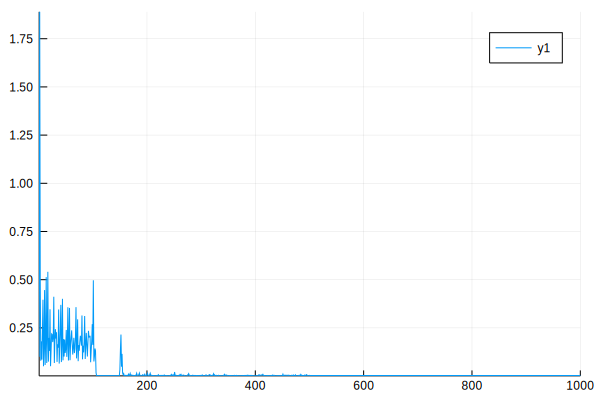

In [16]:
plot(lda_vec_chn[:lf_eps])